In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import DBSCAN

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import pickle


In [14]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


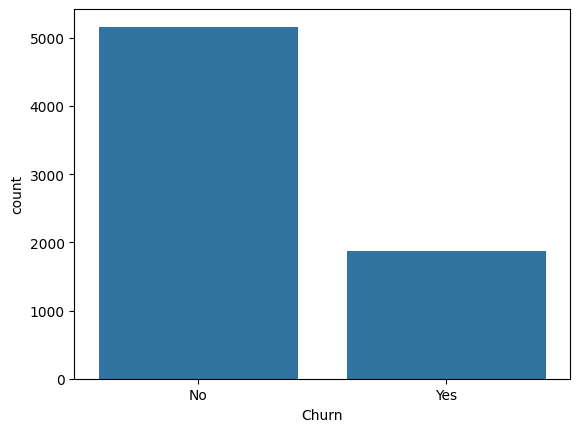

In [15]:
df.info()
df.describe()

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)
df.drop("customerID", axis=1, inplace=True)

sns.countplot(x="Churn", data=df)
plt.show()


In [16]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

label_encoders = {}
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print("Original features:", X_scaled.shape[1])
print("Reduced features:", X_pca.shape[1])


Original features: 19
Reduced features: 16


In [19]:
ica = FastICA(n_components=10, random_state=42)
X_ica = ica.fit_transform(X_scaled)


In [20]:
dbscan = DBSCAN(eps=2, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

df["DBSCAN_Cluster"] = clusters
print(df["DBSCAN_Cluster"].value_counts())


DBSCAN_Cluster
-1      3800
 4       213
 7       180
 12      152
 28      127
        ... 
 156       5
 183       5
 94        5
 180       5
 188       5
Name: count, Length: 193, dtype: int64


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [22]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Bagging": BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100,
        random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100,
        random_state=42
    )
}

print("MODEL COMPARISON\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{name}: {accuracy_score(y_test, preds):.4f}")


MODEL COMPARISON

Logistic Regression: 0.7939
KNN: 0.7484
Naive Bayes: 0.7328
Decision Tree: 0.7107
Random Forest: 0.7811
Bagging: 0.7832
AdaBoost: 0.7918


In [23]:
rf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring="accuracy")
print("Random Forest CV Accuracy:", cv_scores.mean())


Random Forest CV Accuracy: 0.7872571707607058


In [24]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_


In [25]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Final Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report\n", classification_report(y_test, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_test, y_pred))


Final Accuracy: 0.7903340440653873
ROC AUC: 0.8289999534091557

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Confusion Matrix
 [[924 109]
 [186 188]]


In [26]:
with open("model.pkl", "wb") as f:
    pickle.dump(
        {
            "model": best_model,
            "scaler": scaler,
            "label_encoders": label_encoders,
            "target_encoder": target_encoder,
            "columns": X.columns.tolist()
        },
        f
    )

print("✅ model.pkl saved successfully")


✅ model.pkl saved successfully
